In [1]:
import ROOT
from sys import exit
import numpy as np
from numpy.testing import assert_array_equal
from nose.tools import (raises, assert_raises, assert_true,
                        assert_equal, assert_almost_equal)
import root_numpy as rnp
import pandas as pd
from pandas.plotting import scatter_matrix
ROOT.ROOT.EnableImplicitMT()

from sklearn import preprocessing

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

data_in = rnp.root2array("../data/pyTreeAverageSkinK_train.root","pytree",
                         branches=['e0','e1','e2','e3','e4','e5','e6','x','m','dt','gmult','ge','gid','glabel'])
assert_equal(data_in.dtype.names, ('e0','e1','e2','e3','e4','e5','e6','x','m','dt','gmult','ge','gid','glabel'))

#convert to pandas
df = pd.DataFrame(data=data_in)
ncol=df.columns.size
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x)
res_df = pd.DataFrame(x_scaled)
df_g1293 = df[(df['ge'] > 1280) & (df['ge'] < 1305)]
g1293_tot = df_g1293.size/ncol
#print(g1293_tot)
#print(df)
#print(res_df)

#data to torch tensor
X = torch.from_numpy(res_df.values).float().to(torch.device('cpu'))
print(X.shape)
print(len(X))
#print(X)


Welcome to JupyROOT 6.18/04
torch.Size([33256, 14])
33256


In [2]:
#look at data loaded
import matplotlib.pyplot as plt
import plotly.express as px

plt.figure(figsize=(3,1))
fig = px.histogram(df, x="glabel",nbins=8, color="glabel")
fig.update_xaxes(range=[-1, 5])
fig.show()
plt.figure(figsize=(3,1))
fig = px.histogram(df, x="gid",nbins=8, color="gid")
fig.update_xaxes(range=[-1, 5])
fig.show()

fig = px.histogram(df, x="ge",nbins=3400, color="glabel")
fig.update_xaxes(range=[100, 3500])
fig.show()

#fig = px.scatter(df, x="e4",y="e0",color="glabel",opacity=0.5)
#fig.show()


In [3]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 40)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(40, 40)
        self.prelu1 = nn.PReLU(1)
        self.fc3 = nn.Linear(40, 20)
        self.prelu2 = nn.PReLU(1)
        self.out = nn.Linear(20, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu1(a2)
        a3 = self.fc3(h2)
        h3 = self.prelu2(a3)
        a4 = self.out(h3)
        y = self.out_act(a4)
        return y
    
net = Net()
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [4]:
def train_epoch(model, opt, criterion, batch_size=5000):
    model.train()
    losses = []
    correct = 0
    total = 0
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, 0:10]
        #print(x_batch)
        y_batch = X[beg_i:beg_i + batch_size, 12:13]
        #print(y_batch.shape)
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        
        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        #
        # (2) Percent test on batch
        with torch.no_grad():
            y_round = torch.round(y_hat)
            total += y_batch.size(0)
            correct += (y_round == y_batch).sum().item()
            
                
        # (3) Compute diff
        loss = criterion(y_hat, y_batch)
        
        # (3) Compute gradients
        loss.backward()
        
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    
    print('Accuracy of the network on the current batch of data: %f %%' % (
        100 * correct / total))
    return losses

In [5]:
e_losses = []
num_epochs = 1000
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion)

Accuracy of the network on the current batch of data: 67.524657 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy of the network on the current batch of data: 68.381645 %
Accuracy o

Accuracy of the network on the current batch of data: 79.690883 %
Accuracy of the network on the current batch of data: 80.111860 %
Accuracy of the network on the current batch of data: 79.811162 %
Accuracy of the network on the current batch of data: 79.693890 %
Accuracy of the network on the current batch of data: 79.832211 %
Accuracy of the network on the current batch of data: 79.871301 %
Accuracy of the network on the current batch of data: 80.147943 %
Accuracy of the network on the current batch of data: 79.769064 %
Accuracy of the network on the current batch of data: 79.919413 %
Accuracy of the network on the current batch of data: 80.138922 %
Accuracy of the network on the current batch of data: 80.003608 %
Accuracy of the network on the current batch of data: 80.033678 %
Accuracy of the network on the current batch of data: 80.087804 %
Accuracy of the network on the current batch of data: 80.021650 %
Accuracy of the network on the current batch of data: 80.015636 %
Accuracy o

Accuracy of the network on the current batch of data: 81.931080 %
Accuracy of the network on the current batch of data: 82.057373 %
Accuracy of the network on the current batch of data: 82.153596 %
Accuracy of the network on the current batch of data: 81.738634 %
Accuracy of the network on the current batch of data: 82.195694 %
Accuracy of the network on the current batch of data: 82.153596 %
Accuracy of the network on the current batch of data: 82.021289 %
Accuracy of the network on the current batch of data: 82.156603 %
Accuracy of the network on the current batch of data: 82.168631 %
Accuracy of the network on the current batch of data: 82.105485 %
Accuracy of the network on the current batch of data: 82.279889 %
Accuracy of the network on the current batch of data: 82.267861 %
Accuracy of the network on the current batch of data: 81.901010 %
Accuracy of the network on the current batch of data: 82.186673 %
Accuracy of the network on the current batch of data: 82.045345 %
Accuracy o

Accuracy of the network on the current batch of data: 82.806110 %
Accuracy of the network on the current batch of data: 82.655761 %
Accuracy of the network on the current batch of data: 82.526461 %
Accuracy of the network on the current batch of data: 82.673803 %
Accuracy of the network on the current batch of data: 82.748978 %
Accuracy of the network on the current batch of data: 82.538489 %
Accuracy of the network on the current batch of data: 82.640726 %
Accuracy of the network on the current batch of data: 82.745971 %
Accuracy of the network on the current batch of data: 82.592615 %
Accuracy of the network on the current batch of data: 82.670796 %
Accuracy of the network on the current batch of data: 82.502406 %
Accuracy of the network on the current batch of data: 82.640726 %
Accuracy of the network on the current batch of data: 82.827159 %
Accuracy of the network on the current batch of data: 82.640726 %
Accuracy of the network on the current batch of data: 82.610657 %
Accuracy o

Accuracy of the network on the current batch of data: 82.917368 %
Accuracy of the network on the current batch of data: 82.706880 %
Accuracy of the network on the current batch of data: 82.788068 %
Accuracy of the network on the current batch of data: 83.001564 %
Accuracy of the network on the current batch of data: 82.968487 %
Accuracy of the network on the current batch of data: 82.727929 %
Accuracy of the network on the current batch of data: 82.833173 %
Accuracy of the network on the current batch of data: 82.791075 %
Accuracy of the network on the current batch of data: 82.935410 %
Accuracy of the network on the current batch of data: 82.685831 %
Accuracy of the network on the current batch of data: 82.770026 %
Accuracy of the network on the current batch of data: 83.001564 %
Accuracy of the network on the current batch of data: 82.944431 %
Accuracy of the network on the current batch of data: 82.905340 %
Accuracy of the network on the current batch of data: 82.902333 %
Accuracy o

Accuracy of the network on the current batch of data: 82.938417 %
Accuracy of the network on the current batch of data: 82.923382 %
Accuracy of the network on the current batch of data: 83.037647 %
Accuracy of the network on the current batch of data: 82.884292 %
Accuracy of the network on the current batch of data: 82.965480 %
Accuracy of the network on the current batch of data: 82.947438 %
Accuracy of the network on the current batch of data: 82.995550 %
Accuracy of the network on the current batch of data: 82.902333 %
Accuracy of the network on the current batch of data: 82.998557 %
Accuracy of the network on the current batch of data: 82.962473 %
Accuracy of the network on the current batch of data: 82.929396 %
Accuracy of the network on the current batch of data: 83.139885 %
Accuracy of the network on the current batch of data: 83.031633 %
Accuracy of the network on the current batch of data: 82.764013 %
Accuracy of the network on the current batch of data: 83.061703 %
Accuracy o

Accuracy of the network on the current batch of data: 83.019605 %
Accuracy of the network on the current batch of data: 83.070724 %
Accuracy of the network on the current batch of data: 82.962473 %
Accuracy of the network on the current batch of data: 83.103801 %
Accuracy of the network on the current batch of data: 83.052682 %
Accuracy of the network on the current batch of data: 83.121843 %
Accuracy of the network on the current batch of data: 83.061703 %
Accuracy of the network on the current batch of data: 83.061703 %
Accuracy of the network on the current batch of data: 83.025619 %
Accuracy of the network on the current batch of data: 83.040654 %
Accuracy of the network on the current batch of data: 83.058696 %
Accuracy of the network on the current batch of data: 82.929396 %
Accuracy of the network on the current batch of data: 83.037647 %
Accuracy of the network on the current batch of data: 83.097787 %
Accuracy of the network on the current batch of data: 82.965480 %
Accuracy o

Accuracy of the network on the current batch of data: 83.103801 %
Accuracy of the network on the current batch of data: 83.251143 %
Accuracy of the network on the current batch of data: 83.016599 %
Accuracy of the network on the current batch of data: 83.028626 %
Accuracy of the network on the current batch of data: 83.070724 %
Accuracy of the network on the current batch of data: 83.052682 %
Accuracy of the network on the current batch of data: 83.224080 %
Accuracy of the network on the current batch of data: 83.248136 %
Accuracy of the network on the current batch of data: 83.028626 %
Accuracy of the network on the current batch of data: 83.097787 %
Accuracy of the network on the current batch of data: 83.233101 %
Accuracy of the network on the current batch of data: 83.266178 %
Accuracy of the network on the current batch of data: 83.082752 %
Accuracy of the network on the current batch of data: 83.061703 %
Accuracy of the network on the current batch of data: 83.181982 %
Accuracy o

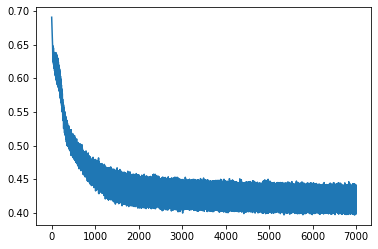

In [6]:
plt.plot(e_losses)
#uncomment below for real python script save
#torch.save(net, "./model_saves/model_J.pt")

In [7]:
net.eval()
with torch.no_grad():
    result = net(X[0:1000000,0:10])

In [8]:
#plt.plot(result.data)
print(torch.max(result))
print(torch.min(result))
torch.histc(result)
df_F = pd.DataFrame(data=result.numpy())
df_F.columns = ["A"]
result_df = pd.concat([df, df_F], axis=1)
ncol_result=result_df.columns.size
fig = px.histogram(df_F,x="A",nbins=100)
fig.update_xaxes(range=[0.0,1.0])
fig.show()

tensor(0.8540)
tensor(0.0348)


              precision    recall  f1-score   support

         0.0       0.87      0.90      0.88     22741
         1.0       0.76      0.72      0.74     10515

    accuracy                           0.84     33256
   macro avg       0.82      0.81      0.81     33256
weighted avg       0.84      0.84      0.84     33256

[[20358  2383]
 [ 2942  7573]]
[[0.89521129 0.10478871]
 [0.27979078 0.72020922]]


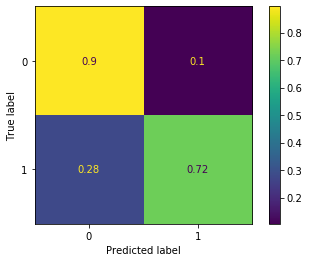

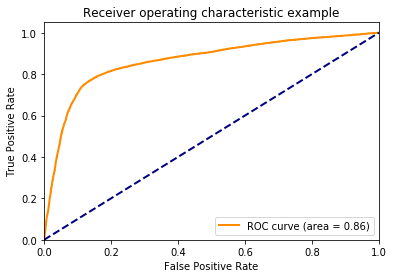

In [9]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
#fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
#y = true labels so for me it is gid [0,1] so no pos_label needed
#scores are output from model
scores=result_df['A'].values
y=result_df['gid'].values
#print(y)
#print(scores)
fpr, tpr, thresholds = metrics.roc_curve(y, scores)
roc_auc = metrics.auc(fpr, tpr)
#metrics.roc_auc_score(y, scores)

#metrics that need binary so using >0.5
scores_round=np.round_(scores,0)
print(metrics.classification_report(y, scores_round))
confusion_matrix=metrics.confusion_matrix(y, scores_round)
confusion_matrix_norm=metrics.confusion_matrix(y, scores_round,normalize='true')
print(confusion_matrix)
print(confusion_matrix_norm)
display_labels=['0','1']
disp = ConfusionMatrixDisplay(confusion_matrix_norm, display_labels)
disp = disp.plot()
plt.show()

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [10]:
#dump to csv
#result_df.to_csv("output/pyTreeAverageFatI_train.csv",sep=" ",header=False)

In [11]:
#print("cut tot% g1293 % g1535 % g383 % g639 % g1190 % g2044 % g2279 % g2978 % g3142 % g1848 %")
total = []
ml_return = []
g1293 = [] #1280-1300
g1535 = [] #1525-1545
g848 = [] #840-860
g383 = [] #380-390
g292 = [] #285-298
g639 = [] # 630-645
g1190 = [] #1180-1200
g2044 = [] #2035-2055
g2279 = [] #2260-2290
g2978 = [] #2960-2990
g3142 = [] #3130-3160
g1848 = [] #1835-1855
g1430 = [] #1420-1440
g2378 = [] #2370-2385
g136 = [] #130-145
g170 = [] #165-175
g1293t = [] #1280-1300
g1535t = [] #1525-1545
g848t = [] #840-860
g383t = [] #380-390
g292t = [] #285-298
g639t = [] # 630-645
g1190t = [] #1180-1200
g2044t = [] #2035-2055
g2279t = [] #2260-2290
g2978t = [] #2960-2990
g3142t = [] #3130-3160
g1848t = [] #1835-1855
g1430t = [] #1420-1440
g2378t = [] #2370-2385
g136t = [] #130-145
g170t = [] #165-175
ratio1 = []
ratio2 = []
ratio3 = []
for cut_val in range(50):
    cut_low=cut_val*0.02
    ml_return.append(cut_low)
    #total count stuff
    total_counts = result_df[(result_df['A'] > 0)]
    total_counts_frac = result_df[(result_df['A'] > cut_low)]
    if (total_counts.size>0):
        total.append(total_counts_frac.size/total_counts.size)
    #g3142 stuff
    g3142_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >3130) 
                   & (result_df['ge'] < 3160) ]
    g3142_tot = result_df[(result_df['ge'] >3130) 
                   & (result_df['ge'] < 3160) ]
    if (g3142_tot.size>0):
        g3142.append(g3142_counts.size/g3142_tot.size)
    g3142t.append(g3142_counts.size/15)
#g848 stuff
    g848_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >845) 
                   & (result_df['ge'] < 855) ]
    g848_tot = result_df[(result_df['ge'] >845) 
                   & (result_df['ge'] < 855) ]
    if (g848_tot.size>0):
        g848.append(g848_counts.size/g848_tot.size)
    g848t.append(g848_counts.size/15)

    #g2978 stuff
    g2978_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2960) 
                   & (result_df['ge'] < 2990) ]
    g2978_tot = result_df[(result_df['ge'] >2960) 
                   & (result_df['ge'] < 2990) ]
    if (g2978_tot.size>0):
        g2978.append(g2978_counts.size/g2978_tot.size)
    g2978t.append(g2978_counts.size/15)
    #g2279 stuff
    g2279_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2260) 
                   & (result_df['ge'] < 2290) ]
    g2279_tot = result_df[(result_df['ge'] >2260) 
                   & (result_df['ge'] < 2290) ]
    if (g2279_tot.size>0):
        g2279.append(g2279_counts.size/g2279_tot.size)
    g2279t.append(g2279_counts.size/15)
    #g2044 stuff
    g2044_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2035) 
                   & (result_df['ge'] < 2055) ]
    g2044_tot = result_df[(result_df['ge'] >2035) 
                   & (result_df['ge'] < 2055) ]
    if (g2044_tot.size>0):
        g2044.append(g2044_counts.size/g2044_tot.size)
    g2044t.append(g2044_counts.size/15)
    #g1293 stuff
    g1293_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1280) 
                   & (result_df['ge'] < 1300) ]
    g1293_tot = result_df[(result_df['ge'] >1280) 
                   & (result_df['ge'] < 1300) ]
    if (g1293_tot.size>0):
        g1293.append(g1293_counts.size/g1293_tot.size)
    g1293t.append(g1293_counts.size/15)
    #g1535 stuff #1525-1545
    g1535_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1525) 
                   & (result_df['ge'] < 1545) ]
    g1535_tot = result_df[(result_df['ge'] >1525) 
                   & (result_df['ge'] < 1545) ]
    if (g1535_tot.size>0):
        g1535.append(g1535_counts.size/g1535_tot.size)
    #g383 stuff
    g383_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >380) 
                   & (result_df['ge'] < 390) ]
    g383_tot = result_df[(result_df['ge'] >380) 
                   & (result_df['ge'] < 390) ]
    if (g383_tot.size>0):
        g383.append(g383_counts.size/g383_tot.size)
    #g292 - 285-298
    g292_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >285) 
                       & (result_df['ge'] < 298) ]
    g292_tot = result_df[(result_df['ge'] >285) 
                       & (result_df['ge'] < 298) ]
    if (g292_tot.size>0):
        g292.append(g292_counts.size/g292_tot.size)
    #g639 - 630-645
    g639_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >630) 
                       & (result_df['ge'] < 645) ]
    g639_tot = result_df[(result_df['ge'] >630) 
                       & (result_df['ge'] < 645) ]
    if (g639_tot.size>0):
        g639.append(g639_counts.size/g639_tot.size)
    #g1190
    g1190_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1170) 
                       & (result_df['ge'] < 1210) ]
    g1190_tot = result_df[(result_df['ge'] >1170) 
                       & (result_df['ge'] < 1210) ]
    if (g1190_tot.size>0):
        g1190.append(g1190_counts.size/g1190_tot.size)
    g1190t.append(g1190_counts.size/15)
    #g1848
    g1848_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1830) 
                       & (result_df['ge'] < 1850) ]
    g1848_tot = result_df[(result_df['ge'] >1830) 
                       & (result_df['ge'] < 1850) ]
    if (g1848_tot.size>0):
        g1848.append(g1848_counts.size/g1848_tot.size)
    #g1848
    g1430_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1420) 
                       & (result_df['ge'] < 1440) ]
    g1430_tot = result_df[(result_df['ge'] >1420) 
                       & (result_df['ge'] < 1440) ]
    if (g1430_tot.size>0):
        g1430.append(g1430_counts.size/g1430_tot.size)
    #g2378
    g2378_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2370) 
                       & (result_df['ge'] < 2390) ]
    g2378_tot = result_df[(result_df['ge'] >2370) 
                       & (result_df['ge'] < 2390) ]
    if (g2378_tot.size>0):
        g2378.append(g2378_counts.size/g2378_tot.size)
    #g136
    g136_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >130) 
                       & (result_df['ge'] < 145) ]
    g136_tot = result_df[(result_df['ge'] >130) 
                       & (result_df['ge'] < 145) ]
    if (g136_tot.size>0):
        g136.append(g136_counts.size/g136_tot.size)
    #g170
    g170_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >160) 
                       & (result_df['ge'] < 185) ]
    g170_tot = result_df[(result_df['ge'] >160) 
                       & (result_df['ge'] < 185) ]
    if (g170_tot.size>0):
        g170.append(g170_counts.size/g170_tot.size)
    ratio1.append(g1190_counts.size/g1293_counts.size)
    ratio2.append(g639_counts.size/g383_counts.size)
    ratio3.append(g3142_counts.size/g1535_counts.size)

df_ratio=pd.DataFrame(ratio1, columns=['1190/1293'])
df_ratio2=pd.DataFrame(ratio2, columns=['639/383'])
df_ratio3=pd.DataFrame(ratio3, columns=['3142/1535'])

df_ratio=pd.concat([df_ratio, df_ratio2], axis=1)
df_ratio=pd.concat([df_ratio, df_ratio3], axis=1)

df_frac=pd.DataFrame(ml_return, columns=['ml_return'])
df_tot=pd.DataFrame(ml_return, columns=['ml_return'])

df1293t=pd.DataFrame(g1293t, columns=['g1293t'])
df1190t=pd.DataFrame(g1190t, columns=['g1190t'])
df3142t=pd.DataFrame(g3142t, columns=['g3142t'])

df_tot=pd.concat([df_tot, df1293t], axis=1)
df_tot=pd.concat([df_tot, df1190t], axis=1)
df_tot=pd.concat([df_tot, df3142t], axis=1)

print(df_tot)
df1293=pd.DataFrame(g1293, columns=['1293'])
df1535=pd.DataFrame(g1535, columns=['1535'])
df383=pd.DataFrame(g383, columns=['383'])
df848=pd.DataFrame(g848, columns=['848'])
df639=pd.DataFrame(g639, columns=['639'])
df1190=pd.DataFrame(g1190, columns=['1190'])
df2044=pd.DataFrame(g2044, columns=['2044'])
df2279=pd.DataFrame(g2279, columns=['2279'])
df2978=pd.DataFrame(g2978, columns=['2978'])
df3142=pd.DataFrame(g3142, columns=['3142'])
df1848=pd.DataFrame(g1848, columns=['1848'])
df1430=pd.DataFrame(g1430, columns=['1430'])
df2378=pd.DataFrame(g2378, columns=['2378'])
df136=pd.DataFrame(g136, columns=['136'])
df170=pd.DataFrame(g170, columns=['170'])

df_frac = pd.concat([df_frac, df1293], axis=1)
df_frac = pd.concat([df_frac, df1535], axis=1)
df_frac = pd.concat([df_frac, df383], axis=1)
df_frac = pd.concat([df_frac, df848], axis=1)
df_frac = pd.concat([df_frac, df639], axis=1)
df_frac = pd.concat([df_frac, df1190], axis=1)
df_frac = pd.concat([df_frac, df2044], axis=1)
df_frac = pd.concat([df_frac, df2279], axis=1)
df_frac = pd.concat([df_frac, df2978], axis=1)
df_frac = pd.concat([df_frac, df3142], axis=1)
df_frac = pd.concat([df_frac, df1848], axis=1)
df_frac = pd.concat([df_frac, df1430], axis=1)
df_frac = pd.concat([df_frac, df2378], axis=1)
df_frac = pd.concat([df_frac, df136], axis=1)
df_frac = pd.concat([df_frac, df170], axis=1)

df_plot = df_frac.set_index('ml_return').T
#print(df_frac)
print(df_ratio)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning:

invalid value encountered in long_scalars



    ml_return  g1293t  g1190t  g3142t
0        0.00  5512.0   794.0   454.0
1        0.02  5512.0   794.0   454.0
2        0.04  5512.0   794.0   454.0
3        0.06  5485.0   772.0   442.0
4        0.08  5411.0   748.0   421.0
5        0.10  5096.0   604.0   379.0
6        0.12  4975.0   538.0   363.0
7        0.14  4883.0   492.0   349.0
8        0.16  4837.0   451.0   341.0
9        0.18  4794.0   423.0   324.0
10       0.20  4768.0   403.0   303.0
11       0.22  4730.0   377.0   292.0
12       0.24  4701.0   356.0   282.0
13       0.26  4662.0   332.0   272.0
14       0.28  4628.0   315.0   262.0
15       0.30  4588.0   300.0   243.0
16       0.32  4550.0   292.0   230.0
17       0.34  4518.0   277.0   221.0
18       0.36  4482.0   267.0   215.0
19       0.38  4460.0   262.0   205.0
20       0.40  4428.0   256.0   197.0
21       0.42  4399.0   249.0   190.0
22       0.44  4369.0   240.0   179.0
23       0.46  4339.0   231.0   177.0
24       0.48  4295.0   224.0   169.0
25       0.5

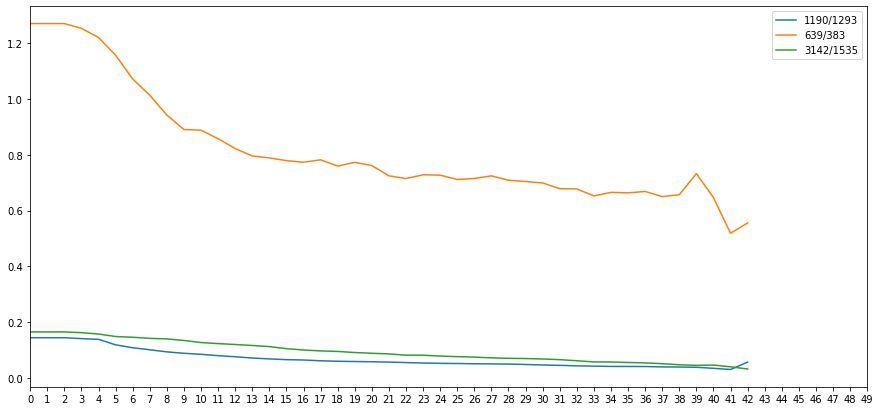

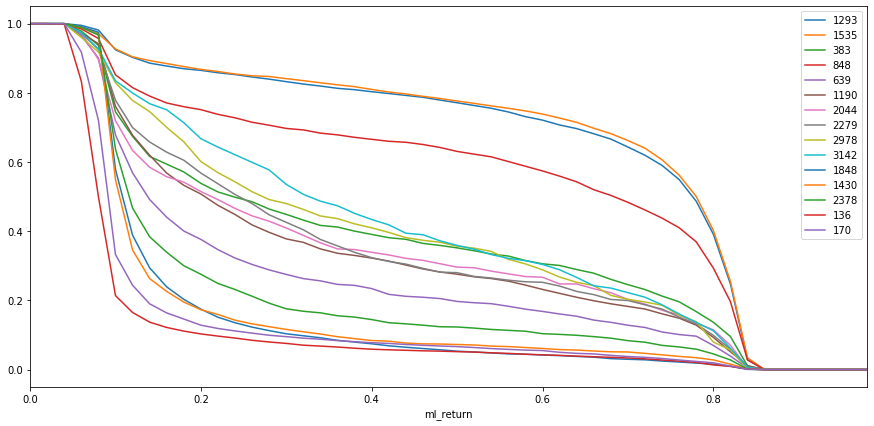

In [12]:
Headers = df_frac.columns.values.tolist()
import plotly.graph_objs as go
from plotly import tools

df_ratio.plot(figsize=(15,7), xticks=range(0, 50)).legend(bbox_to_anchor=(1, 1))
df_frac.plot.line(x='ml_return',figsize=(15,7)).legend(bbox_to_anchor=(1, 1))

In [14]:
#print(total_counts)
ndim_result=result_df.columns.size
#print(result_df)
s38_low=0.5
cl38_high=0.0
s38 = result_df[(result_df['A'] > s38_low) & (result_df['A'] < 1)]
cl38 = result_df[(result_df['A'] < cl38_high) & (result_df['A'] < 1)]
misc = result_df[(result_df['A'] > cl38_high) & (result_df['A'] < s38_low)]

g1293a = result_df[(result_df['A'] > s38_low) & (result_df['ge'] >1280) 
                   & (result_df['ge'] < 1300)]
g1293_s38 = g1293a.size/15
g1293b = result_df[(result_df['A'] < cl38_high) & (result_df['ge'] >1280) 
                   & (result_df['ge'] < 1300)]
g1293_cl38 = g1293b.size/15
g1293c = result_df[(result_df['A'] > cl38_high) & (result_df['A'] < s38_low)
                   & (result_df['ge'] >1280) & (result_df['ge'] < 1300)]
g1293_misc = g1293c.size/15

plt.figure(figsize=(10,4))
fig = px.histogram(s38, x="ge", nbins=3400, color = "glabel")
fig.update_xaxes(range=[100, 3500])
fig.show()

plt.figure(figsize=(10,4))
fig = px.histogram(cl38, x="ge", nbins=3400, color = "glabel")
fig.update_xaxes(range=[100, 3500])
fig.show()

plt.figure(figsize=(10,4))
fig = px.histogram(misc, x="ge", nbins=3400, color = "glabel")
fig.update_xaxes(range=[100, 3500])
fig.show()


KeyError: 'glabel'

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>